In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.autograd import Variable
from IPython.display import Image
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# arguments

In [2]:
batch_size = 128
epochs = 10
num_labels = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Prepare Dataset

In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
download_root = './MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

In [5]:
train_loader = DataLoader(dataset=train_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

# a, _ = test_dataset.__getitem__(0)
# torch.tensor(np.array(a))
# 28*28 shape data

In [6]:
def label_to_one_hot(label, num_labels = 10):
    label = label.unsqueeze(1)
    one_hot = torch.zeros([label.shape[0], num_labels], device = device)
    one_hot.scatter_(1, label, 1)
    return one_hot

# Define Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.MLP= nn.Sequential(nn.Linear(28*28, 400), nn.PReLU(),
                                nn.Linear(400, 20))
        
    def forward(self, x):
        bs = x.shape[0]
        out = self.MLP(x.reshape(bs, -1))
        return out
        

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.MLP = nn.Sequential(nn.Linear(20+10, 400), nn.PReLU(),
                                nn.Linear(400, 28*28), nn.Sigmoid())
        
    def forward(self, x, label):
        bs = x.shape[0]
        c = label_to_one_hot(label)
        out = self.MLP(torch.cat([x,c], dim = 1)).reshape(bs, 1, 28, 28)
        return out
        

In [9]:
class Codebook(nn.Module):
    def __init__(self, K = 128, D = 20, commitment_cost = 0.25):
        super(Codebook, self).__init__()
        self.D = D
        self.K = K
        self.embedding = nn.Embedding(num_embeddings = K, embedding_dim = D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)
        self._commitment_cost = commitment_cost

    def forward(self, z_e_x):
        dist = (torch.sum(z_e_x**2, dim=1, keepdim=True)
                + torch.sum(self.embedding.weight**2, dim=1)
                - 2 * torch.matmul(z_e_x, self.embedding.weight.t()))
        
        indices = torch.argmin(dist, dim=1)
        encodings = F.one_hot(indices, num_classes = self.K).float()
        encodings.to(z_e_x.device)
        z_q_x = torch.matmul(encodings, self.embedding.weight)
        
        # Loss
        e_latent_loss = F.mse_loss(z_q_x.detach(), z_e_x, reduction='sum')
        q_latent_loss = F.mse_loss(z_q_x, z_e_x.detach(), reduction='sum')
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        z_q_x = z_e_x + (z_q_x - z_e_x).detach()

        return z_q_x, loss

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.codebook = Codebook()
        
    def forward(self, x, label):
        z = self.encoder(x)
        z_q, vq_loss = self.codebook(z)
        out = self.decoder(z_q, label)
        
        return out, vq_loss

# model prepare

In [11]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
recon_criterion = nn.MSELoss(reduction='sum')

In [12]:
for epoch in range(0, epochs):
    for iteration, (data, label) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        recon,vq_loss = model(data.to(device), label.to(device))
        recon_loss = recon_criterion(recon, data.to(device))
        loss = vq_loss + recon_loss
        
        loss.backward()
        optimizer.step()
        
    loss = 0
    for iteration, (data, label) in enumerate(test_loader):
        model.eval()
        with torch.no_grad():
            recon, kld_loss = model(data.to(device), label.to(device))

            recon_loss = recon_criterion(recon, data.to(device))
            loss += (kld_loss + recon_loss)

    print(epoch, loss/test_dataset.__len__())

0 tensor(113.5990, device='cuda:0')
1 tensor(91.9472, device='cuda:0')
2 tensor(87.4056, device='cuda:0')
3 tensor(85.0009, device='cuda:0')
4 tensor(83.7669, device='cuda:0')
5 tensor(83.6994, device='cuda:0')
6 tensor(81.7451, device='cuda:0')
7 tensor(81.6644, device='cuda:0')
8 tensor(79.6547, device='cuda:0')
9 tensor(79.8564, device='cuda:0')


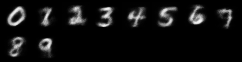

In [13]:
z = Normal(0,1).sample((10,20)).to(device)
label = torch.tensor(np.arange(0,10), device = device).long()
# label = torch.tensor(np.random.randint(0,10,32), device = device).long()
out = model.decoder(z, label)
save_image(out.view(out.size(0), 1, 28, 28).data.cpu(), 'sample_image.png')
Image('sample_image.png')